# **Gender Classification**

* **Kaggle T4x2 GPU Runtime older than Jan 30**
* **Dataset**: UTK Face new
* *UTK Face is a large diverse Benchmark Dataset used for facial recognition, gender, race classification, age estimation and classification problems.*

In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

2024-03-24 13:33:09.797480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 13:33:09.797583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 13:33:09.963333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

BATCH_SIZE = 32
IMAGE_SIZE = 224

Total number of images  : 23708
Sample Image path       : 1_0_3_20161220222642427.jpg.chip.jpg
Sample Age              : 1
Sample Gender           : Male



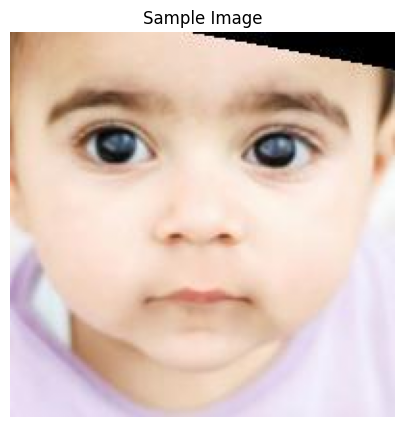

In [3]:
# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

gender_mapping = ["Male", "Female"]

rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [4]:
male_count = 0
ages = []
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

female_count = len(image_paths) - male_count
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()
bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



**We have 52:48 male/female ratio, we could get better accuracy as of now but the model will definitely be biased slightly to males**

In [5]:
# Violin and Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

**The Age distribution is very biased for particular age groups asper dataset we would train age with two datasets namely augmented dataset on UTK and facial age and this one seperately**

In [6]:
np.random.shuffle(image_paths)
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    train_images,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Validation Size  : {len(valid_images)}")
print(f"Testing Size  : {len(test_images)}")

train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 19203
Validation Size  : 2134
Testing Size  : 2371


Because we have a lot of images, it will be better to use **Tensorflow data set** for efficiency.

In [7]:
def show_image(image, show=False):
    plt.imshow(image)
    plt.axis("off")
    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [8]:
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

Lets check the dataset

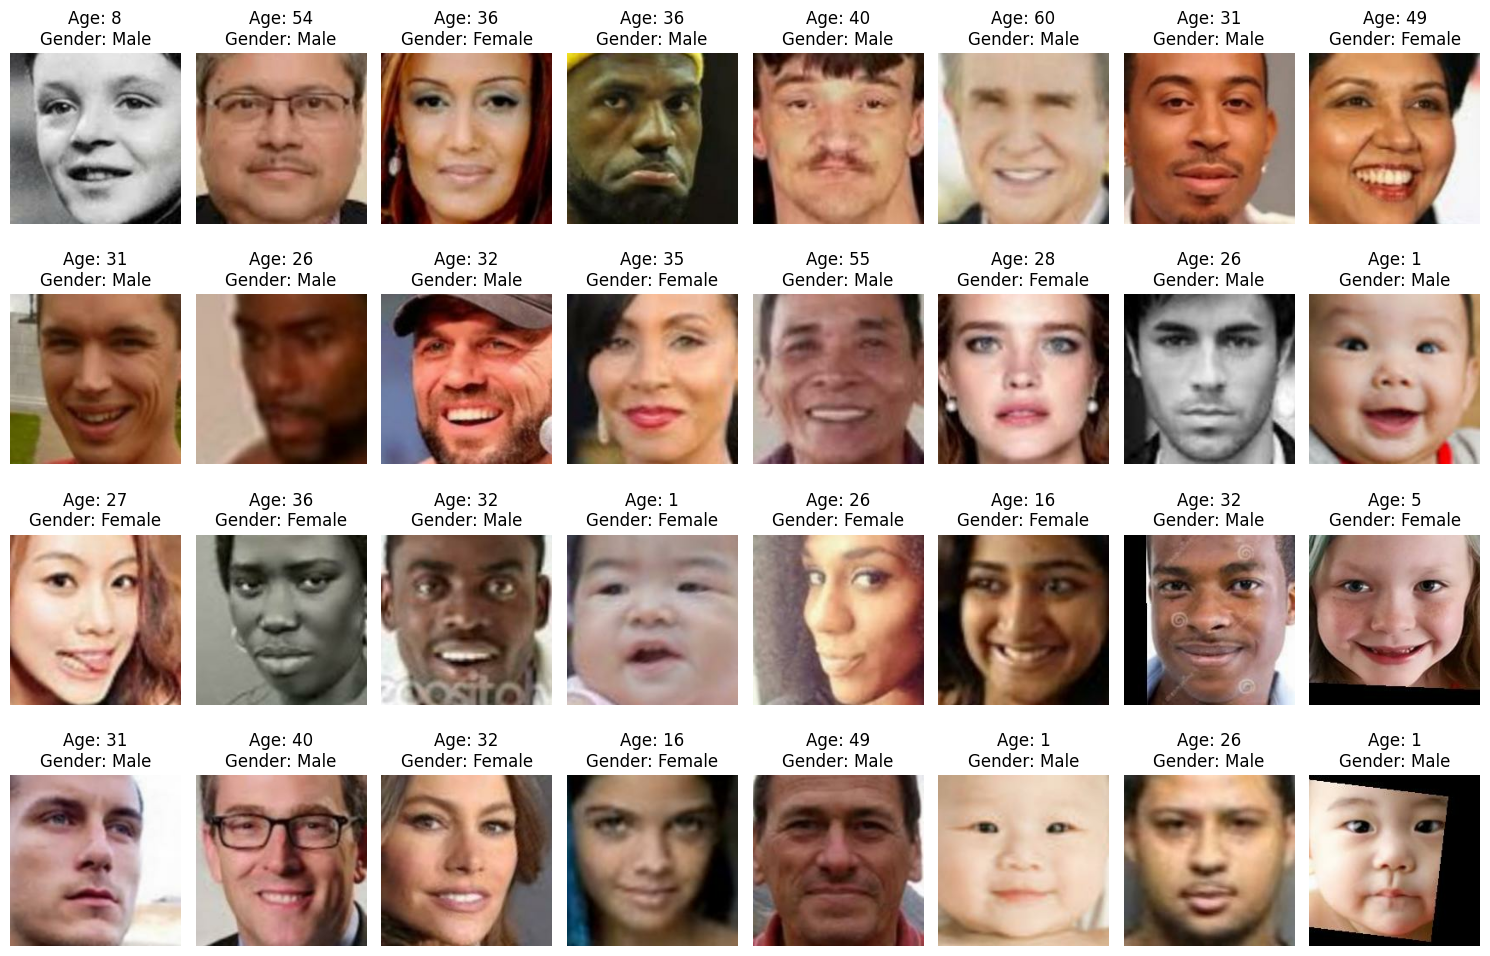

In [9]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

**We tested multiple model pretrained backbones, Xception, Mobilenet, Inception, Vgg, Resnet. Xception and Vgg16 has better results with Vgg having a smooth learning curve, Resnet150 worked better for gender classification**

In [15]:
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")
vgg_16.trainable = False
age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name = "SlightDroput"),
    Flatten(name="FlattenEmbeddings"),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dense(1, name="AgeOutput")
], name="AgeNet")
age_net.compile(
    loss = "mae",
    optimizer = 'adam',
    weighted_metrics=[]
)

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
age_history = age_net.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_loss",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Age-VGG16.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20


2024-03-24 13:33:37.349911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inAgeNet/SlightDroput/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711287228.266352      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


601/601 [==============================] - 114s 169ms/step - loss: 9.4727 - val_loss: 8.7670
Epoch 2/20
601/601 [==============================] - 99s 165ms/step - loss: 7.9829 - val_loss: 8.1889
Epoch 3/20
601/601 [==============================] - 99s 164ms/step - loss: 7.5327 - val_loss: 7.2894
Epoch 4/20
601/601 [==============================] - 99s 164ms/step - loss: 7.1425 - val_loss: 7.1985
Epoch 5/20
601/601 [==============================] - 98s 164ms/step - loss: 6.9922 - val_loss: 7.9828
Epoch 6/20
601/601 [==============================] - 98s 163ms/step - loss: 6.8368 - val_loss: 7.5820
Epoch 7/20
601/601 [==============================] - 98s 162ms/step - loss: 6.6511 - val_loss: 7.6403
Epoch 8/20
601/601 [==============================] - 99s 164ms/step - loss: 6.5386 - val_loss: 6.9992
Epoch 9/20
601/601 [==============================] - 98s 163ms/step - loss: 6.4795 - val_loss: 7.0234
Epoch 10/20
601/601 [==============================] - 99s 164ms/step - loss: 6.354

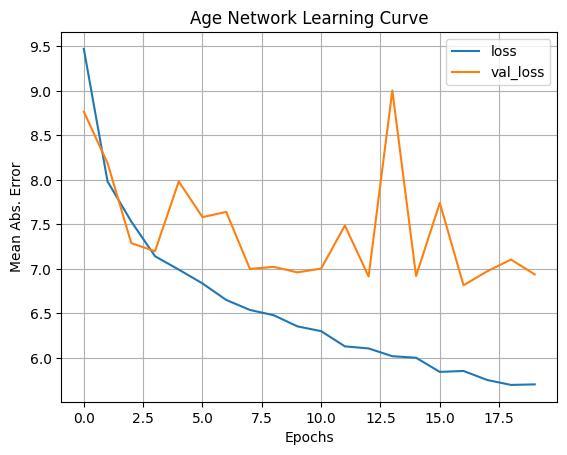

In [17]:
age_his_df = pd.DataFrame(age_history.history)
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

In [18]:
age_net.save('age.keras')

*The mae was around 6.9 on validation dataset which seemed like a decent model but other approach was employed on top of this with the augmented dataset in the other notebook.*

**Gender Classification**

In [19]:
resnet = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights="imagenet")
resnet.trainable = False
gender_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

234545216/234545216 [==============================] - 3s 0us/step


In [20]:
gender_history = gender_net.fit(
    train_gender_ds,
    validation_data = valid_gender_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20


2024-03-24 14:07:07.417311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenderNet/SlightDroput/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


601/601 [==============================] - 164s 255ms/step - loss: 0.4040 - accuracy: 0.8150 - val_loss: 0.3373 - val_accuracy: 0.8688
Epoch 2/20
601/601 [==============================] - 142s 236ms/step - loss: 0.3352 - accuracy: 0.8513 - val_loss: 0.3667 - val_accuracy: 0.8421
Epoch 3/20
601/601 [==============================] - 145s 242ms/step - loss: 0.3176 - accuracy: 0.8622 - val_loss: 0.3293 - val_accuracy: 0.8660
Epoch 4/20
601/601 [==============================] - 145s 242ms/step - loss: 0.3064 - accuracy: 0.8643 - val_loss: 0.3112 - val_accuracy: 0.8716
Epoch 5/20
601/601 [==============================] - 142s 236ms/step - loss: 0.2987 - accuracy: 0.8694 - val_loss: 0.3119 - val_accuracy: 0.8725
Epoch 6/20
601/601 [==============================] - 146s 243ms/step - loss: 0.2926 - accuracy: 0.8740 - val_loss: 0.3060 - val_accuracy: 0.8791
Epoch 7/20
601/601 [==============================] - 142s 236ms/step - loss: 0.2893 - accuracy: 0.8760 - val_loss: 0.3194 - val_accura

Let's analyse the learning curves of both models to gain some insights.

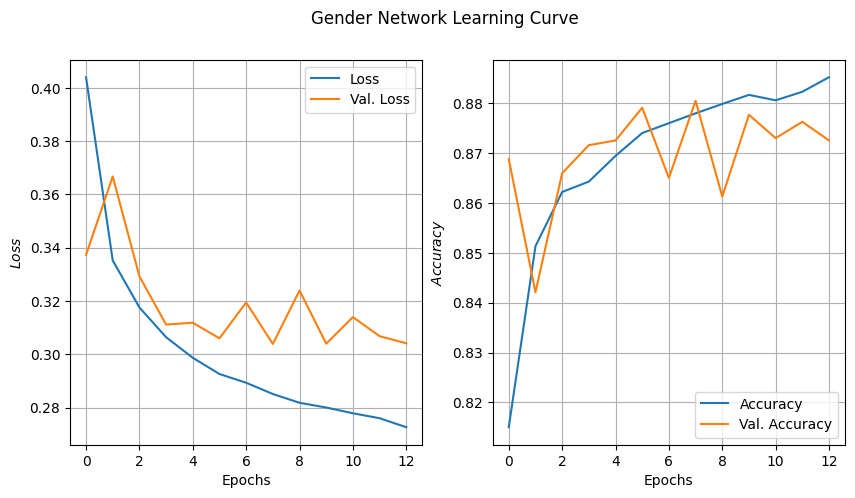

In [21]:
gender_his_df = pd.DataFrame(gender_history.history)

plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()
plt.show()

In [22]:
gender_net.save('gender.keras')

*We achieved 87.5% accuracy which seems good enough and the erraneous images where mostly blurred or asian males with slightly extra hair were predicted as females, the accuracy of children is also fairly poor which is expected*

In [24]:
age_net = tf.keras.models.load_model("/kaggle/working/Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("/kaggle/working/Gender-ResNet152.keras", compile=True)

In [25]:
age_net.evaluate(test_age_ds)
gender_net.evaluate(test_gender_ds)

75/75 [==============================] - 21s 229ms/step - loss: 0.2949 - accuracy: 0.8760


[0.29492834210395813, 0.8760017156600952]

*In the test dataset the results are consistent with the validation which shows how accurate the predictions are.*

**Visualising**

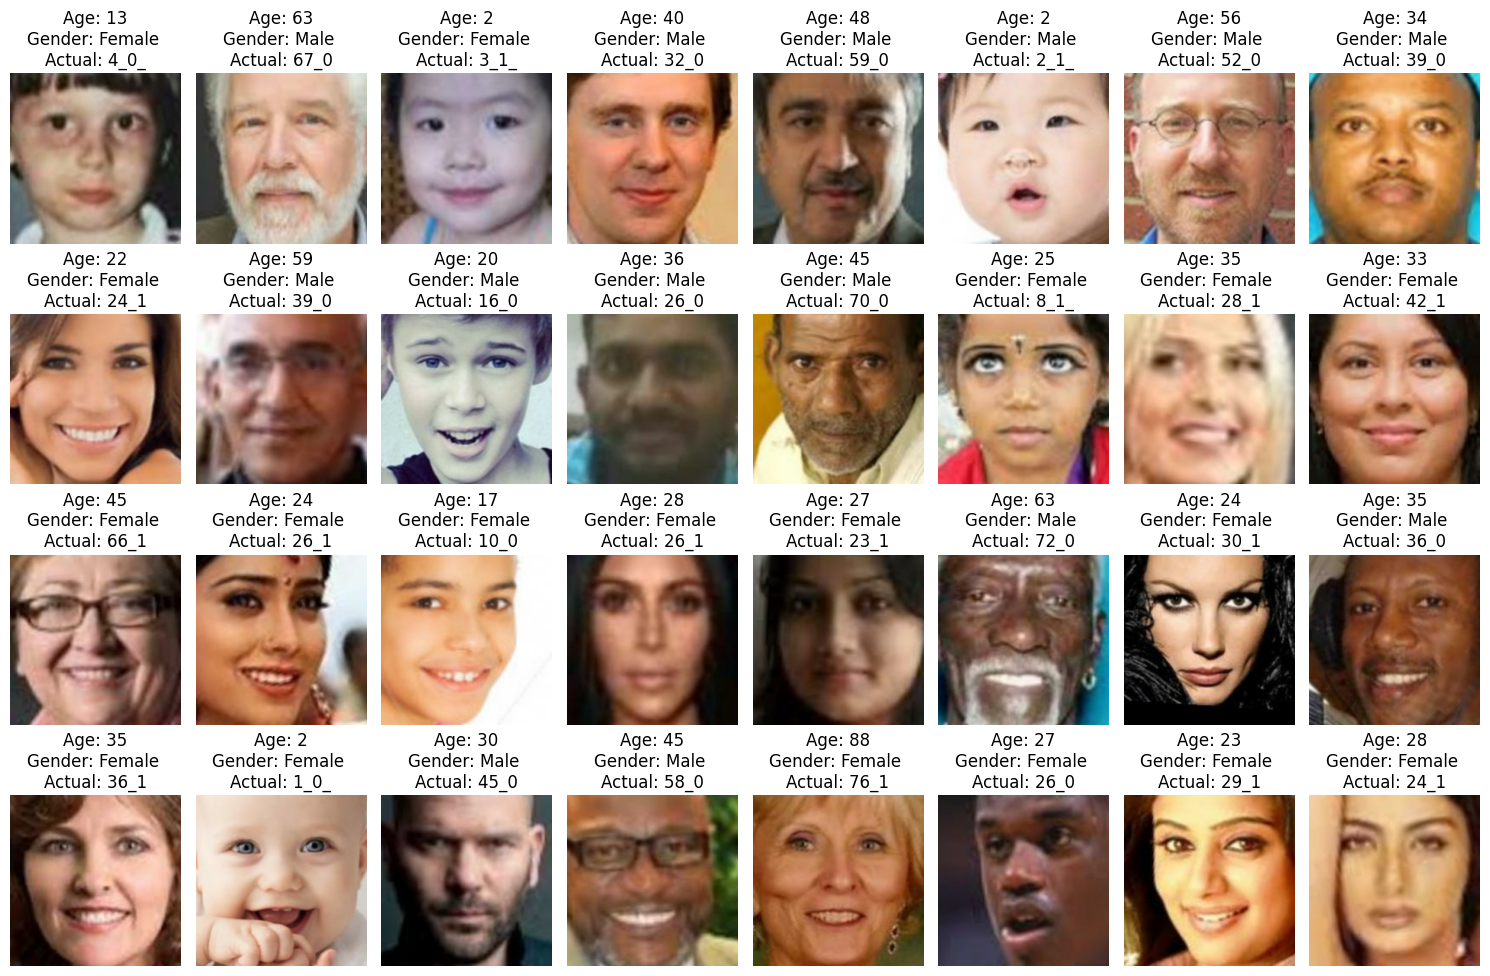

In [26]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        pred_age = tf.round(tf.squeeze(age_net.predict(image, verbose=0)), 2)
        pred_gender = tf.round(tf.squeeze(gender_net.predict(image, verbose=0)))
        string_value = images[index].numpy().decode('utf-8')
        ftc = string_value[:4]
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)}\nGender: {gender_mapping[int(pred_gender)]} \nActual: {ftc}")
        plt.axis("off")

plt.tight_layout()
plt.show()

The gender accuracy is decent and for age we have improvised on this with our multi dataset multi model average estimation. Predicting age group would have given more accurate data. Exact age estimation is not possible to human eye without +/- 5 yrs error. Also asper some reddit articles some of the data in UTK are wrongly annotated and blurred or with text to. Follow the next age notebook for training on Augmented dataset on Facial Age and UTK